In [1]:
import pickle, gzip
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt
import os
import math

In [2]:
from ConvolutionalNeuralNetwork import ConvolutionalNeuralNetwork
from Standardization import Standardization
from DigitDataset import DigitDataset
from CollateFunction import collate_fn
import CNNModelAnalysis as CMA

In [3]:
home = os.path.expanduser('~')
data_fpath = home + '/myNotebooks/Notebooks_old/mnist.pkl.gz'

# Load the dataset
with gzip.open(data_fpath, 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [4]:
use_gpu = True 

Xtrain, Ttrain = train_set
Xvalid, Tvalid = valid_set
Xtest, Ttest = test_set 

img_channel = 1
wh = int(np.sqrt(Xtrain.shape[1] / img_channel))
Xtrain, Xvalid, Xtest = (x.reshape(-1, img_channel, wh, wh) for x in [Xtrain, Xvalid, Xtest])

st_obj = Standardization(Xtrain)

split_tuples_list = [(Xtrain, Ttrain), (Xvalid, Tvalid), (Xtest, Ttest)]

dataset_list = [DigitDataset(stup, st_obj) for stup in split_tuples_list]

batch_size_list = [256, 256, 256] if use_gpu else [32, 32, 32] # [100, 100, 100]
shuffle_list = [True, False, False]

trainloader, validloader, testloader = (torch.utils.data.DataLoader(dataset, 
                                                                    batch_size = batch_size, 
                                                                    collate_fn = collate_fn, 
                                                                    shuffle = shuffle) 
                                        for dataset, batch_size, shuffle 
                                        in zip(dataset_list, batch_size_list, shuffle_list))

In [5]:
preds_list = []
confs_list = []
evaluation_res_list = []

train_error_list = []
train_error_trace_list = []

valid_error_list = []
valid_error_trace_list = []

height = Xtrain.shape[2]
width = Xtrain.shape[3]
in_channels = Xtrain.shape[1] 
classes = np.unique(Ttrain)
use_gpu = True

# Elements in each arch
# (n_units_in_conv_layers[...], 
# kernel_size_and_stride_padding[[],[],...], 
# maxpool_kernel_stride_padding[[],[],...], 
# n_units_in_fc_layers[...])

arch_list = [([2, 3], [[3, 3, 0], [2, 2, 0]], [None, None], [3]), 
             ([5, 4], [[3, 3, 0], [2, 2, 0]], [None, None], [5]), 
             ([10, 20], [[3, 3, 0], [2, 2, 0]], [None, None], [10]), 
             ([1, 2], [[3, 3, 0], [2, 2, 0]], [None, None], [])]

lr_list = [0.02, 0.03, 0.01, 0.01]
n_epochs_list = [20, 10, 10, 20]

best_vloss = None
states_path = './saved_states/mnist_model_states.pth'

torch.manual_seed(42)

for arch, learning_rate, n_epochs in zip(arch_list, lr_list, n_epochs_list):

    print('|', end=' ')
    
    n_units_in_conv_layers, kernel_size_and_stride_padding, maxpool_kernel_stride_padding, n_units_in_fc_layers = arch

    conv_model = ConvolutionalNeuralNetwork(in_channels, width, height, 
                                          n_units_in_conv_layers, kernel_size_and_stride_padding, 
                                            maxpool_kernel_stride_padding, n_units_in_fc_layers, 
                                          classes, use_gpu)
    
    conv_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss, states_path = states_path)
    best_vloss = conv_model.get_best_validation_loss()
    
    train_error_trace, valid_error_trace = conv_model.get_error_trace()
    train_error = train_error_trace[-1]
    valid_error = valid_error_trace[-1]
    train_error_trace_list.append(train_error_trace)
    train_error_list.append(train_error)
    valid_error_trace_list.append(valid_error_trace)
    valid_error_list.append(valid_error)
    
    Y_preds, Y_confs = conv_model.predict(testloader) #trainloader
    confs_list.append(Y_confs)
    preds_list.append(Y_preds)
    evaluation_res_list.append(conv_model.evaluate(testloader))

| | | | 

In [6]:
# Show the initial results of the experiments.

pandas.set_option('display.max_colwidth', None)
pandas.DataFrame([arch_list, n_epochs_list, lr_list, train_error_list, valid_error_list, evaluation_res_list], 
                 index = ['Model Arch', 'Epochs', 'lr', 'Tr-loss', 'Val-loss', 'Test Acc']).T

,Model Arch,Epochs,lr,Tr-loss,Val-loss,Test Acc
0,"([2, 3], [[3, 3, 0], [2, 2, 0]], [None, None], [3])",20,0.02,0.686736,0.629972,0.7975
1,"([5, 4], [[3, 3, 0], [2, 2, 0]], [None, None], [5])",10,0.03,0.360068,0.343617,0.8948
2,"([10, 20], [[3, 3, 0], [2, 2, 0]], [None, None], [10])",10,0.01,0.095743,0.117574,0.9615
3,"([1, 2], [[3, 3, 0], [2, 2, 0]], [None, None], [])",20,0.01,0.718894,0.671106,0.7812


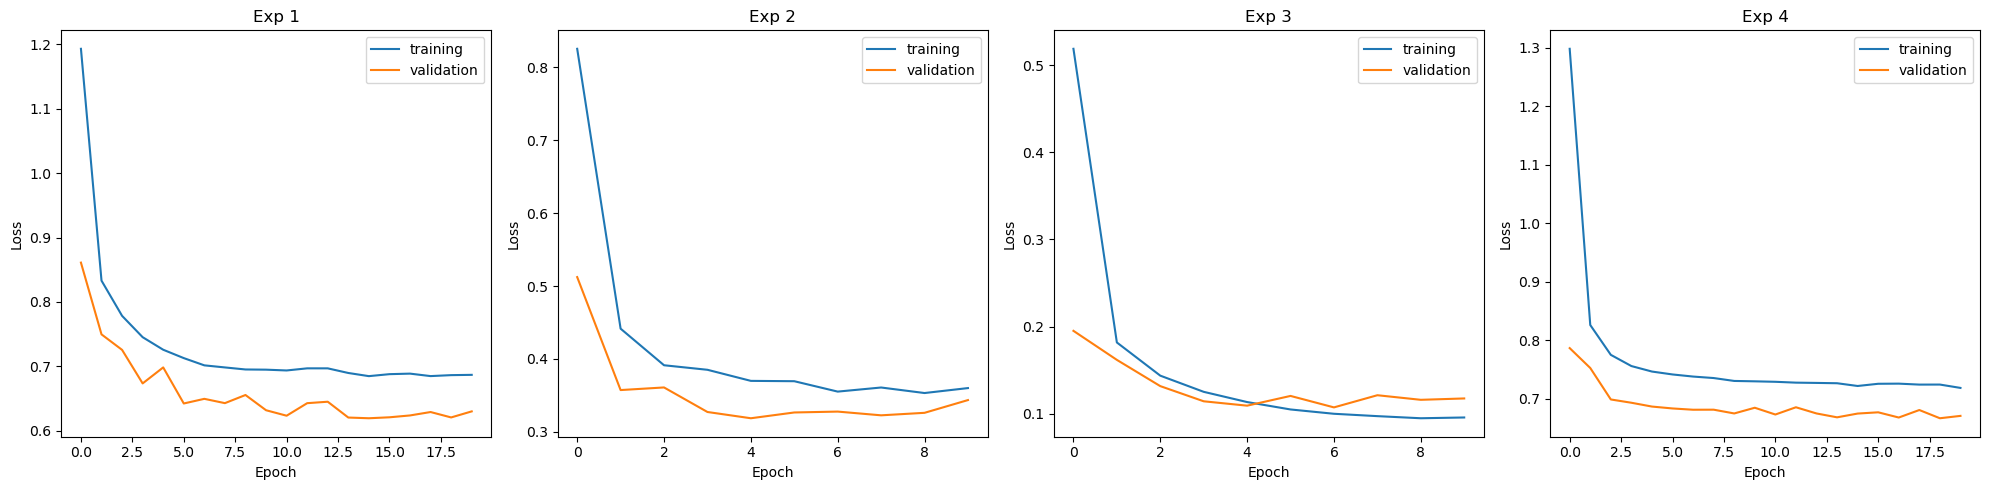

In [7]:
# Plot loss curve for training and validation set.

plt.figure(figsize = (20, 5))
n = len(arch_list)
col = 4
row = math.ceil(n/col)
for i in range(n):
    plt.subplot(row, col, i+1)
    plt.plot(train_error_trace_list[i], label = 'training')
    plt.plot(valid_error_trace_list[i], label = 'validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Exp {i+1}')
plt.tight_layout()

In [8]:
# Best validation loss
print(f'best validation loss: {best_vloss:.4}')

best validation loss: 0.1073


In [12]:
# Choose the network with better result, change anything needed, and train longer.

states_path = './saved_states/mnist_model_states.pth'

checkpoint = torch.load(states_path)
best_args = checkpoint['model_args']
n_epochs = checkpoint['epoch']
learning_rate = checkpoint['loss']

in_channels, width, height, n_units_in_conv_layers, kernel_size_and_stride_padding, maxpool_kernel_stride_padding, n_units_in_fc_layers, classes, use_gpu, dropout, bnorm = best_args

# Change if you need to -
#n_units_in_conv_layers = [32, 64, 128] 
#kernel_size_and_stride_padding = [[3, 3, 0], [2, 2, 0], [2, 1, 0]] 
#maxpool_kernel_stride_padding = [[2, 1, 0], [2, 1, 0], [2, 1, 0]] 
#n_units_in_fc_layers = [] 

learning_rate = 0.01
n_epochs = 30
dropout = None #0.4
bnorm = False

# Specify a new path for saving the states of this trial.
best_vloss = None
states_path = './saved_states/mnist_model_states_trial.pth'

conv_model = ConvolutionalNeuralNetwork(in_channels, width, height, 
                                      n_units_in_conv_layers, kernel_size_and_stride_padding, 
                                        maxpool_kernel_stride_padding, n_units_in_fc_layers, 
                                      classes, use_gpu, dropout, bnorm)

# Now either load the trained model's states and retrain (uncomment the following line)
#conv_model.nnet.load_state_dict(checkpoint['model_state_dict'])

conv_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss = best_vloss, states_path = states_path)
best_vloss = conv_model.get_best_validation_loss()
print(f'Best validation loss: {best_vloss:.3f}')

train_error_trace, valid_error_trace = conv_model.get_error_trace()

Y_preds, Y_confs = conv_model.predict(testloader)
Test_acc = conv_model.evaluate(testloader)
print(f'Test Accuracy: {Test_acc:.3f}')

Best validation loss: 0.111
Test Accuracy: 0.962


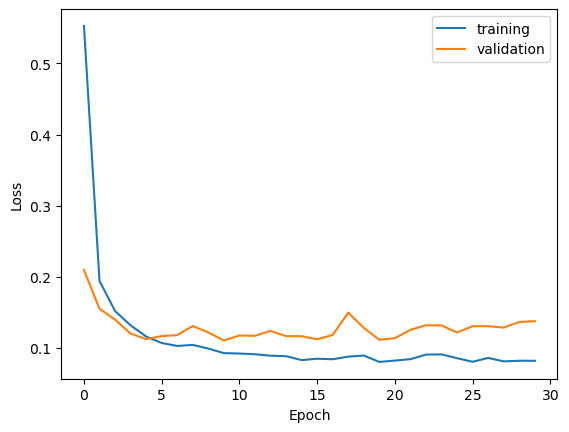

In [13]:
# Loss plot of the final model.

plt.plot(train_error_trace, label = 'training')
plt.plot(valid_error_trace, label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

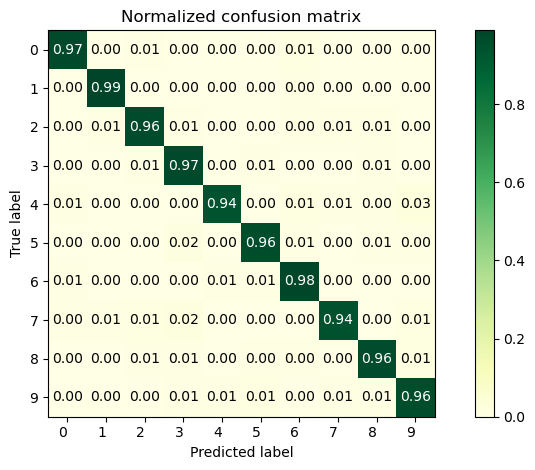

In [14]:
# Add confusion matrix on test set, recall, precision, f1-score, auroc

Pte, Prte = conv_model.predict(testloader) #nnet.use(Xtenn)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
CMA.plot_confusion_matrix(Ttest, Pte, classes=np.unique(Ttest).astype(int),
                      title='Normalized confusion matrix')

plt.show()

In [15]:
# Use the preferred trained model to test on a different set of samples (rerun the dataloader cell to get a different set).
# Use either './saved_states/mnist_model_states.pth' or './saved_states/mnist_model_states_trial.pth'

reuse_states_path = './saved_states/mnist_model_states_trial.pth'
checkpoint = torch.load(reuse_states_path)

conv_model_resume = ConvolutionalNeuralNetwork(*checkpoint['model_args'])

conv_model_resume.nnet.load_state_dict(checkpoint['model_state_dict'])
Y_pred, Y_conf = conv_model_resume.predict(testloader) 
eval_result = conv_model_resume.evaluate(testloader)
print(f'{eval_result:.4f}')

0.9664


## Visualize some predictions from test samples

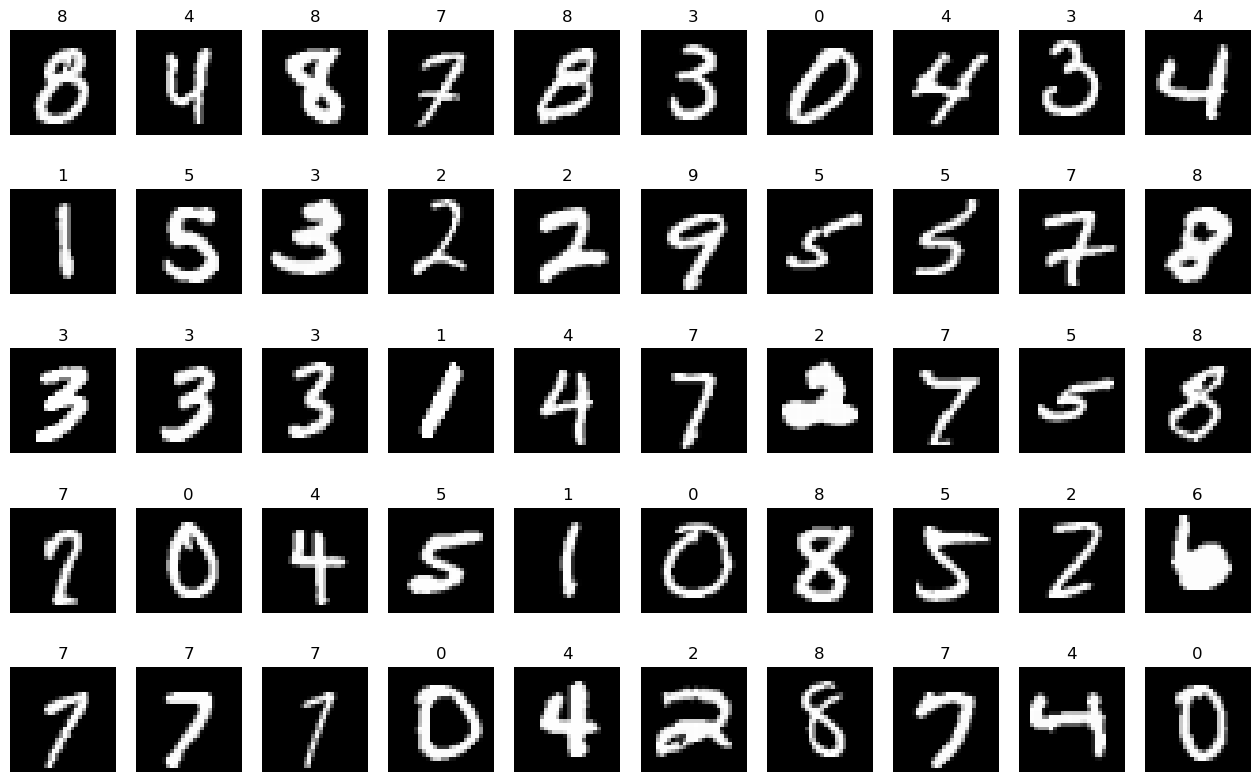

In [16]:
plt.figure(figsize = (16, 10))
row = 5
col = 10
total = int(row * col)
rand_ind = np.random.randint(0, len(Xtest), total)
for i in range(total):
    plt.subplot(row, col, i+1)
    #img = plt.imread(test_dir + '/' + testset[rand_ind[i]])
    img = Xtest[rand_ind[i]].transpose(1, 2, 0)
    plt.imshow(img, cmap = 'gray')
    plt.title(label = Y_pred[rand_ind[i]])
    plt.axis('off');